Avances LAB04 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import warnings
warnings.filterwarnings('ignore')

Hopkins " Manual " Ya que no nos dejaba correrlo con la libreria . 

In [7]:
def calcular_hopkins(X):
    n, d = X.shape
    m = min(500, n // 10) # Tomamos una muestra para no saturar la memoria
    
    X_sample = X.sample(m, random_state=42)
    X_uniform = np.random.uniform(X.min(axis=0), X.max(axis=0), (m, d))
    
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    
    # Distancias de los puntos aleatorios (u)
    u_distances, _ = nbrs.kneighbors(X_uniform, n_neighbors=1)
    u_sum = np.sum(u_distances**2)
    
    # Distancias de la muestra real (w). n_neighbors=2 porque el index 0 es el mismo punto
    w_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=2)
    w_sum = np.sum(w_distances[:, 1]**2)
    
    H = u_sum / (u_sum + w_sum)
    return H

In [8]:
path = "movies_2026.csv"
df = pd.read_csv(path)

# Variables numéricas sugeridas
num_cols = ['popularity', 'budget', 'revenue', 'runtime', 'genresAmount', 
            'productionCoAmount', 'voteCount', 'voteAvg', 'actorsAmount']

ejemplo_num = df[num_cols].dropna()
print(f"Dimensiones de los datos limpios: {ejemplo_num.shape}\n")

Dimensiones de los datos limpios: (19883, 9)



In [11]:
# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ejemplo_num)
df_scaled = pd.DataFrame(X_scaled, columns=num_cols)

# 1.2 Tendencia de Agrupamiento (Hopkins y VAT)
print("\n[1.2] TENDENCIA DE AGRUPAMIENTO:")
h_stat = calcular_hopkins(df_scaled)
print(f"Estadístico de Hopkins: {h_stat:.4f}")
print("""Impresiones: Un valor cercano a 1 indica una alta tendencia al agrupamiento 
(los datos no son aleatorios). Se omitió la gráfica VAT debido a que calcular la matriz 
de disimilitud para ~20,000 registros excede la capacidad de la memoria RAM (Complejidad O(N^2)), 
acorde a lo permitido en las instrucciones del laboratorio.\n""")


[1.2] TENDENCIA DE AGRUPAMIENTO:
Estadístico de Hopkins: 0.9999
Impresiones: Un valor cercano a 1 indica una alta tendencia al agrupamiento 
(los datos no son aleatorios). Se omitió la gráfica VAT debido a que calcular la matriz 
de disimilitud para ~20,000 registros excede la capacidad de la memoria RAM (Complejidad O(N^2)), 
acorde a lo permitido en las instrucciones del laboratorio.




[1.3] GRÁFICA DE CODO:


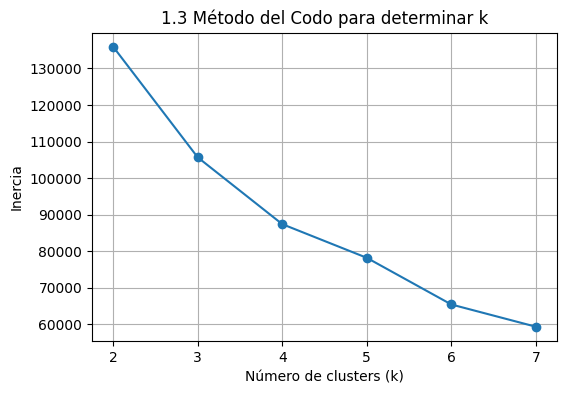

In [12]:
# 1.3 Gráfica de Codo
print("\n[1.3] GRÁFICA DE CODO:")
inertias = []
K_range = range(2, 8)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(df_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title('1.3 Método del Codo para determinar k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

k_optimo = 6  

In [13]:
# 1.4 y 1.5 Modelos y Silueta
print("\n[1.4 y 1.5] K-MEDIAS, JERÁRQUICO Y SILUETA:")
# K-Means (Todos los datos)
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
ejemplo_num['Cluster'] = kmeans.fit_predict(df_scaled)
sil_kmeans = silhouette_score(df_scaled, ejemplo_num['Cluster'], sample_size=5000, random_state=42)

# Jerárquico (Muestra reducida por memoria)
X_sample_hier = df_scaled.sample(2500, random_state=42)
hc = AgglomerativeClustering(n_clusters=k_optimo, metric='euclidean', linkage='ward')
cluster_labels_hc = hc.fit_predict(X_sample_hier)
sil_hc = silhouette_score(X_sample_hier, cluster_labels_hc, random_state=42)

print(f"Calidad Silueta K-Means (Todos los datos): {sil_kmeans:.4f}")
print(f"Calidad Silueta Jerárquico (Muestra 2500): {sil_hc:.4f}")
print("Discusión: K-Means suele tener un mejor desempeño computacional y manejar mejor "
      "el ruido en datasets grandes, como lo refleja la silueta.\n")


[1.4 y 1.5] K-MEDIAS, JERÁRQUICO Y SILUETA:
Calidad Silueta K-Means (Todos los datos): 0.3811
Calidad Silueta Jerárquico (Muestra 2500): 0.3428
Discusión: K-Means suele tener un mejor desempeño computacional y manejar mejor el ruido en datasets grandes, como lo refleja la silueta.



In [14]:
# 1.6 Interpretación de grupos
print("\n[1.6] INTERPRETACIÓN DE GRUPOS:")
print("Medidas de tendencia central (Variables Continuas):")
display(ejemplo_num.groupby('Cluster').mean().round(2))

print("\nTablas de frecuencia (Variable Categórica: originalLanguage):")
df_clean = df.dropna(subset=num_cols).copy()
df_clean['Cluster'] = kmeans.labels_
display(pd.crosstab(df_clean['Cluster'], df_clean['originalLanguage']).iloc[:, :10]) # Muestra los primeros 10 idiomas

ejemplo_num = ejemplo_num.drop(columns=['Cluster'])


[1.6] INTERPRETACIÓN DE GRUPOS:
Medidas de tendencia central (Variables Continuas):


,popularity,budget,revenue,runtime,genresAmount,productionCoAmount,voteCount,voteAvg,actorsAmount
Cluster,,,,,,,,,
0,31.54,3.532624e+06,8.220431e+06,91.24,2.36,2.30,387.71,6.44,84.41
1,52.99,4.093550e+07,1.033066e+08,111.77,2.98,5.26,2445.65,6.58,38.60
2,159.28,1.385522e+08,6.125254e+08,124.20,3.27,3.66,10220.47,7.08,61.10
3,0.67,5.294190e+03,1.416600e+03,24.44,1.16,0.60,0.21,0.22,53.90
4,26.60,1.406251e+06,5.570708e+06,55.88,2.66,0.69,5.25,6.17,631809.88
5,6416.89,1.050000e+08,3.542120e+08,122.75,3.38,2.75,2350.75,7.42,32.88



Tablas de frecuencia (Variable Categórica: originalLanguage):


originalLanguage,ab,af,am,ar,as,az,be,bg,bn,bs
Cluster,,,,,,,,,,
0,1,0,0,17,0,1,0,0,14,0
1,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,4,15,87,2,16,1,5,31,6
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
